In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/faeron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Анализ на първа база данни

In [2]:
users = pd.read_csv("data/users.csv")

In [3]:
users_cols_to_drop = [
    "FacebookId", "PictureId", "FacebookProfilePageLink", "FacebookUserName", "AdditionalInfo",
    "PhoneNumber", "IsAdmin", "DelayRateRequestDate", "IsModerator", "IsCustomFBLink"
]

In [4]:
users = users.drop(columns = users_cols_to_drop)

In [5]:
users.LastLoggedIn = users.LastLoggedIn.astype("str")
users.BirthDate = users.BirthDate.astype("str")

In [6]:
lambda_cut = lambda x: x[:4]

users.Created = users.Created.apply(lambda_cut)
users.BirthDate = users.BirthDate.apply(lambda_cut)
users.LastLoggedIn = users.LastLoggedIn.apply(lambda_cut)
users.LastModified = users.LastModified.apply(lambda_cut)

In [7]:
users[['BirthDate', 'Created', 'LastLoggedIn', 'Gender']] = users[['BirthDate', 'Created', 'LastLoggedIn', 'Gender']].apply(pd.to_numeric, errors = 'coerce').astype('Int64')

In [8]:
users.head()

,Id,DisplayName,Email,BirthDate,IsActivated,Created,LastLoggedIn,LastModified,Gender,UnsubscribedFromMails,IsBanned
0,000094dc-b322-488a-b345-e1418e8cfc29,milenauto,milenauto@abv.bg,<NA>,0,2019,2021,2020,0,0,0
1,00016423-8d76-4fcd-8bbd-42ba430dfed5,Боян Смилов,boyan.smilov@gmail.com,<NA>,0,2018,2018,2018,0,0,0
2,00033634-8b8b-4203-9ca7-101ccb07c901,Presian Mladenov,jebb@mail.bg,<NA>,1,2019,2022,2022,0,0,0
3,0003ed08-9b7b-4f38-9d8a-31354663a1e7,Evgeni Ivanov,evgeniivanov444@gmail.com,<NA>,0,2017,2017,2017,0,0,0
4,0004a94e-5717-4e50-b8c7-f0471fc316d9,Галина Йочева,yochevaa@gmail.com,<NA>,1,2018,2021,2021,1,0,0


In [9]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
BirthDate,892.0,1990.651345,7.417225,1937.0,1988.0,1993.0,1996.0,1999.0
IsActivated,32575.0,0.527398,0.499256,0.0,0.0,1.0,1.0,1.0
Created,32575.0,2019.209486,1.962803,2017.0,2017.0,2019.0,2021.0,2023.0
LastLoggedIn,32528.0,2020.04636,2.136171,2017.0,2018.0,2020.0,2022.0,2023.0
Gender,23792.0,0.41329,0.492434,0.0,0.0,0.0,1.0,1.0
IsBanned,32575.0,0.000153,0.012388,0.0,0.0,0.0,0.0,1.0


In [10]:
users.Gender.value_counts(), users.IsBanned.value_counts()

(Gender
 0    13959
 1     9833
 Name: count, dtype: Int64,
 IsBanned
 0    32570
 1        5
 Name: count, dtype: int64)

In [11]:
users.isnull().sum()

Id                           0
DisplayName                 24
Email                     2494
BirthDate                31683
IsActivated                  0
Created                      0
LastLoggedIn                47
LastModified                 0
Gender                    8783
UnsubscribedFromMails        2
IsBanned                     0
dtype: int64

### Основни Наблюдения:

1. Виждаме, че за огромен брой потребители рожденната дата липсва. От наличните данни виждаме, че голяма част от потребителите са родени над 1988 година (75%), а 50% от тях са над 1993та. Оказва се, че няма потребители родени над 1999 година, извод, който не изглежда реалистичен и трябва да се провери.

2. От извадка от 32,575 потребителя 52.7% са с активирани акаунти. На този етап не можем да заявим дали това е добър процент, предварително трябва да се проучат други подобни бизнеси и да се разбере техният Activation Rate.

3. Средната стойност в променливата LastLoggedIn показва, че голяма част от потребителите в базата данни са неактивни, над 75% не са били активни в приложението от 2022 година.

4. 27% от потребителите предпочитат да запазят информацията за пола си анонимна (значителен процент, който показва недоволството на клиентите относно събирането на този вид данни).

5. От останалите 23,792 човека, около 59% са мъже и 41% са жени, което показва значително подобен интерес и при двата пола.

6. Процентът баннати потребители е изключително незначителен.

<br>

## Анализ на отделни променливи

### 1. Рожденна дата

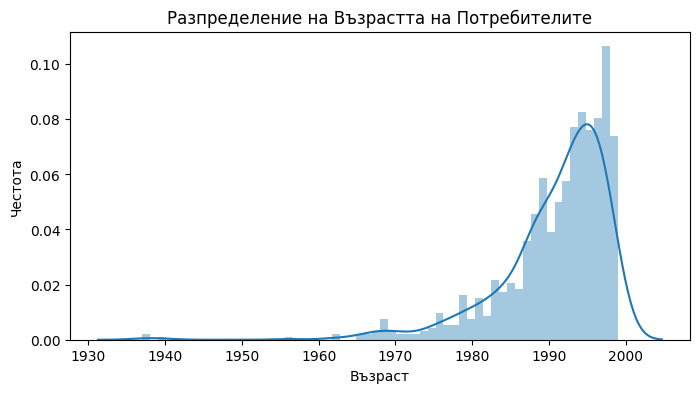

In [12]:
plt.figure(figsize = (8, 4))

sns.distplot(users.BirthDate.dropna(), bins = 60)

plt.title("Разпределение на Възрастта на Потребителите")
plt.xlabel("Възраст")
plt.ylabel("Честота")

plt.show()

#### Открития и препоръки:

1. Имайки предвид, че имаме рожденна дата на около 1000 потребителя, може да приемем, че това е една добра представителна извадка от цялата база данни.

2. Целеви пазар: Разбирането на диапазона от години на раждане на основните потребители помага на бизнеса да определи своя целеви пазар. Както виждаме, основната аудитория принадлежи към поколението на милениалите, бизнесът може да приспособи своите продукти, услуги и маркетингови стратегии, за да отговори по-добре на предпочитанията, нуждите и ценностите на тази специфична демографска група.

3. Дигитално поколение: Това означава, че бизнесът може да се съсредоточи върху онлайн и дигитални маркетингови канали, за да се ангажира ефективно с целевата си аудитория. Развиването на силно онлайн присъствие, използването на социални медийни платформи и създаването на удобни за мобилни устройства изживявания могат да бъдат жизненоважни за достигане и свързване с клиенти от тази група.

4. Осъзнаване на стойност и целенасоченост: Милениалите често дават приоритет на стойността и целта, когато вземат решения за покупка. Те са склонни да търсят продукти и услуги, които са в съответствие с техните лични ценности, включително устойчивост и етични практики. Бизнесите, които могат да демонстрират своя ангажимент към тези ценности, имат възможността да резонират с групата клиенти и да изградят лоялност към марката.

5. Инициативи за социална отговорност: Милениалите често подкрепят бизнеси, които демонстрират социална отговорност. Компаниите могат да участват в благотворителни партньорства, да дарят част от печалбите си за кауза или да стартират инициативи, насочени към социални проблеми. Чрез привеждането на марката си в съответствие със социална кауза, бизнесът може да резонира с милениалите, които са мотивирани да оказват положително влияние в обществото.

6. Съдържание, генерирано от потребителите, и маркетинг с влияние: Милениалите се доверяват на мненията и препоръките на своите връстници. Бизнесът може да насърчи клиентите на хилядолетието да споделят своя опит чрез генерирано от потребителите съдържание, като рецензии, препоръки и публикации в социалните медии. Освен това сътрудничеството с инфлуенсъри, които имат силни хилядолетни последователи, може да помогне за повишаване на познаваемостта на марката и доверието сред тази демографска група.

    - Mоже да добавим провеждане на конкурси или раздаване на подаръци в социалните медии и споделяне на ценно съдържание, което резонира с интересите и ценностите на поколението. Социалните медии могат да се използват и за показване на моменти "зад кулисите" на бизнеса и истории на клиенти.
    
<br>

### 2. Активиране на Акаунт 

In [13]:
users.IsActivated.value_counts(), users.IsActivated.value_counts(normalize = True)

(IsActivated
 1    17180
 0    15395
 Name: count, dtype: int64,
 IsActivated
 1    0.527398
 0    0.472602
 Name: proportion, dtype: float64)

#### Открития и препоръки:

1. Положителен процент на активиране: Степента на активиране може да бъде индикация за ангажираност на потребителите и интерес към предложенията на приложението. Това показва, че значителен брой потребители са предприели необходимите стъпки, за да започнат да използват функциите на приложението.

2. Потенциал за растеж: С 52,7% от потребителите, които активират акаунтите си, все още има потенциал за увеличаване на потребителската база чрез насърчаване на повече потребители да активират своите акаунти. Това може да се постигне чрез целенасочени маркетингови кампании, стимули за потребителите или подобряване на процеса на включване.

3. Стратегии за задържане: Важно е да се съсредоточим върху задържането на активираните потребители и насърчаването им да продължат да използват приложението редовно. Внедряването на стратегии за задържане като персонализирани изживявания, непрекъсната комуникация и ценни функции може да помогне за поддържане на ангажираността и лоялността на потребителите.

5. Сравнителен анализ: Би било полезно да сравним степента на активиране с индустриалните стандарти или конкуренти, за да оцените ефективността на приложението спрямо други. Този сравнителен анализ може да предостави информация за областите за подобрение и задаване на реалистични цели.

    - Доклад от 2022 г. на OpenView установява нива на активиране между 14% и 33% за различни компании. Следователно, нашият процент е над "добър".
    
    - Как да подобрим процентът активации:
    
        - Опростяване на регистрацията и адаптирането
        
        - Потребителите реагират най-добре на прост, директен език, а не на сложни параграфи. Би било да се уверим, че езикът в приложението е директен и фокусиран върху ползите.
        
        - Използване на контролни списъци и геймификация
            - Постижения и значки
            - Точки за използване за козметични надстройки
            - Класации сред членовете на 
            - Ленти за напредъка на изпълнението на целта
            
        - Имплементиране на База от Знания (център за ресурси) с ръководства и инструкции, често задавани въпроси, публикации в блогове и др.
        
        - Получаване на мейл за добре дошли
        
        - Съобщенията за жизнения цикъл също са чудесен начин да върнем неактивните потребители (напр. потребител, който не е активирал акаунта си) обратно в системата.
        
<br>

### 3. Последна Активност

In [14]:
users.LastLoggedIn.value_counts(), users.LastLoggedIn.value_counts(normalize = True)

(LastLoggedIn
 2022    5912
 2023    5504
 2017    5421
 2019    4883
 2018    4554
 2021    3426
 2020    2828
 Name: count, dtype: Int64,
 LastLoggedIn
 2022    0.181751
 2023    0.169208
 2017    0.166656
 2019    0.150117
 2018    0.140002
 2021    0.105325
 2020     0.08694
 Name: proportion, dtype: Float64)

#### Открития и препоръки:

- От предоставената информация може да се заключи, че сравнително нисък процент потребители (17%) са били активни през последната година от общата потребителска база от 32 575. Това предполага, че може да има спад или липса на ангажираност сред потребителите с течение на времето.

- Въз основа на това заключение някои препоръки могат да бъдат:

    - Подобряване на ангажираността на потребителите: Прилагане на стратегии за увеличаване на ангажираността на потребителите и насърчаване на активно участие. Това може да включва предоставяне на стимули, въвеждане на нови функции или актуализации, провеждане на потребителски проучвания, за да се разберат техните нужди и предпочитания, и предлагане на персонализирани изживявания.

    - Подобряване на услугата: Оценка на текущите предложения и идентифициране на областите за подобрение. Може да се помисли за добавяне на нови функции, подобряване на потребителското изживяване и справяне с всички болкови точки или предизвикателства, пред които са изправени потребителите. Това може да помогне за привличането и задържането на повече активни потребители.

    - Анализиране на поведението и предпочитанията на потребителите: Извършване на задълбочен анализ на поведението и предпочитанията на потребителите, за да разберем защо процентът на активните потребители е нисък. Идентифициране на всички модели или тенденции, които могат да дадат представа за причините за ниската ангажираност. Този анализ може да помогне за приспособяване на стратегии и инициативи за по-добро посрещане на нуждите и очакванията на потребителите.

    - Комуникационни и маркетингови усилия: Укрепване на комуникационните канали с потребителите и прилагане на целенасочени маркетингови усилия за повторно ангажиране на неактивни потребители. Това може да включва персонализирани имейли, известия или специални оферти, които да ги насърчат да посетят отново и да се ангажират с платформата.

    - Активно събиране на обратна връзка от потребителите: Активно търсене на обратна връзка от потребителите, за да се разберат техните притеснения, предизвикателства и предложения за подобрение. Тази обратна връзка може да насочи бъдещото развитие и подобрения за по-добро съответствие с очакванията на потребителите.
    
<br>

### 4. Пол на потребителите

In [15]:
users.Gender.value_counts(), users.Gender.value_counts(normalize = True)

(Gender
 0    13959
 1     9833
 Name: count, dtype: Int64,
 Gender
 0    0.58671
 1    0.41329
 Name: proportion, dtype: Float64)

#### Открития и препоръки:

Въз основа на предоставената информация могат да се направят няколко извода и препоръки:

 - Неразкриване на пола: Фактът, че 8783 потребители са решили да не споделят пола си, показва значителна част от потребителската база, която може да има опасения за поверителността или предпочита да не разкрива тази информация. Важно е да се зачита изборът на поверителност на потребителите и да се гарантира, че платформата поддържа подходящи мерки за защита на данните.

- Разпределение по пол: Сред потребителите, които са разкрили своя пол, приблизително 59% са мъже и 41% са жени. Това предполага дисбаланс между половете в рамките на потребителската база, с по-голямо представителство на мъже потребители. 

- Приобщаване и разнообразие: За да се създаде по-приобщаваща и разнообразна платформа, е важно да се насърчат потребителите да споделят своята информация за пола, като същевременно се гарантира, че тя е незадължителна и зачита тяхната поверителност. Прилагането на инициативи за насърчаване на разнообразието, като целенасочени маркетингови кампании, приобщаващ език и функции, които отговарят на разнообразните потребителски нужди, може да помогне за привличането и задържането на по-разнообразна потребителска база.

<br>

### 5. Отписани от имейли

In [16]:
users.UnsubscribedFromMails.value_counts(), users.UnsubscribedFromMails.value_counts(normalize = True)

(UnsubscribedFromMails
 0                             31697
 1                               875
 2023-06-22 14:54:28.327751        1
 Name: count, dtype: int64,
 UnsubscribedFromMails
 0                             0.973107
 1                             0.026863
 2023-06-22 14:54:28.327751    0.000031
 Name: proportion, dtype: float64)

#### Открития и препоръки:

Въз основа на предоставената информация приблизително 97,46% от клиентите все още получават имейли. Това предполага, че по-голямата част от клиентите все още са активни получатели на имейли.

- Преглеждане съдържанието и честотата на имейлите: Струва си да прегледаме съдържанието, честотата и уместността на имейлите, изпращани на клиентите. Ще е добре да оценим дали имейлите предоставят стойност и отговарят на очакванията на клиентите и да помислим за провеждане на проучвания или събиране на обратна връзка от абонирани клиенти, за да разберем причините им да се откажат и да идентифицирате области за подобрение.

- Подобряване ангажираността с имейлите: Подобряване на цялостното качество на имейлите, като се съсредоточим върху фактори като завладяващи теми, ценно съдържание, привлекателни визуални ефекти и ясен призив за действие. Един добре проектиран и ангажиращ имейл може да привлече вниманието на клиентите и да увеличи вероятността те да останат абонирани.

- Сегментиране и персонализиране: Прилагането на целенасочени имейл кампании въз основа на предпочитанията и интересите на клиента може да помогне за подобряване на ангажираността и намаляване на броя на отписаните абонаменти. Чрез сегментиране на клиентската база и приспособяване на имейл съдържанието към конкретни сегменти, можем да осигурим по-персонализирана и подходяща комуникация, която е в съответствие с техните нужди и интереси.

<br>

### 6. Корелации между променливите

In [17]:
numeric_cols = users.select_dtypes(include = ['float', 'int'])
correlation_matrix = numeric_cols.corr()

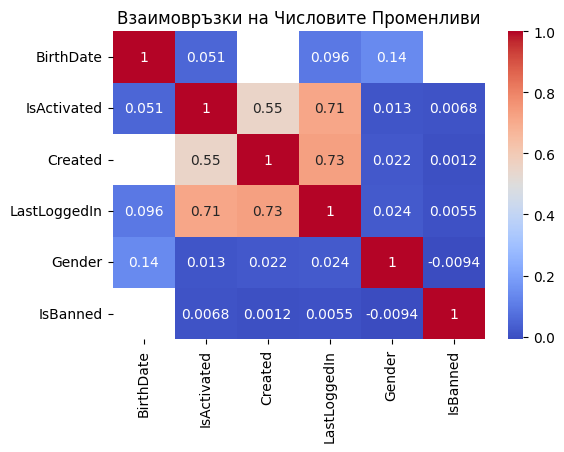

In [18]:
plt.figure(figsize = (6, 4))

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')

plt.title('Взаимовръзки на Числовите Променливи')
plt.show()

#### Открития и наблюдения:

- В този контекст, корелация от 0,71 показва, че има относително силна връзка между времето на създаване на акаунта и вероятността за активиране на акаунта. Това предполага, че има тенденция акаунтите, създадени в определени моменти, да бъдат по-вероятно да бъдат активирани.

- Въз основа на тази корелация можем да заключим, че може да има определени фактори или модели, свързани с времето за създаване на акаунта, които влияят върху активирането на акаунтите. Може да си струва да проучим допълнително тези фактори, за да идентифицираме всякакви прозрения или тенденции, които могат да помогнат за подобряване на процента на активиране.

<br>

Нека разгледаме тази взаимовръзка по-подробно:

In [19]:
users_filtered = users[['Created', 'IsActivated']]

grouped_data = users_filtered.groupby('Created')['IsActivated'].mean()

sorted_data = grouped_data.sort_index()

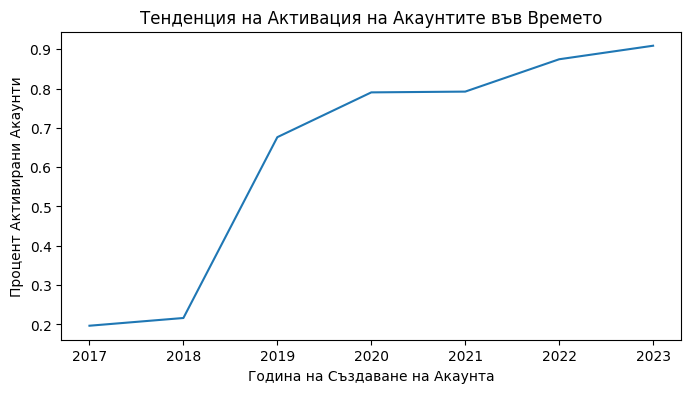

In [20]:
plt.figure(figsize = (8, 4))

plt.plot(sorted_data.index, sorted_data.values)

plt.title('Тенденция на Активация на Акаунтите във Времето')
plt.xlabel('Година на Създаване на Акаунта')
plt.ylabel('Процент Активирани Акаунти')

plt.show()

In [21]:
sorted_data

Created
2017    0.196648
2018    0.216302
2019    0.676237
2020    0.790142
2021    0.792089
2022    0.874373
2023    0.908807
Name: IsActivated, dtype: float64

#### Открития и препоръки:

Въз основа на предоставените нива на активиране за всяка година могат да се направят следните изводи:

- Степента на активиране като цяло се е увеличила през годините. Започвайки от 2017 г. с процент на активиране от 19,7%, процентите непрекъснато се повишават, достигайки максимум от 90,9% през 2023 г.

- Има значително увеличение на нивата на активиране от 2019 г. нататък. Процентът на активиране се е увеличил повече от два пъти от 2018 г. (21,6%) до 2019 г. (67,6%) и е продължил да нараства през следващите години.

- Най-високите нива на активиране се наблюдават през последните години, като 2022 (87,4%) и 2023 (90,9%) показват най-високи проценти.

Въз основа на тези заключения могат да се направят следните препоръки:
 
- Анализ на конкретните промени или инициативи, въведени през 2019 г., които са довели до значителен скок в нивата на активиране. Разбирането на причините зад това подобрение може да помогне за възпроизвеждането на успешните стратегии в бъдещи инициативи.

- Да помислим за проучване на факторите, допринасящи за изключително високите нива на активиране през 2022 г. и 2023 г. Идентифицирането на двигателите на успеха през тези периоди може да помогне за оптимизиране на усилията за активиране и поддържане на висока производителност в бъдеще.

<br>

# Анализ на втора база данни

В тази секция ще разгледаме повече детайли за потребителите

In [22]:
instances = pd.read_csv("data/willdriveinstances.csv")

In [23]:
towns = pd.read_csv("data/towns.csv")

In [24]:
merged_df = pd.merge(instances, towns[['Id', 'Name']], left_on = 'FromDestinationId', right_on = 'Id', how = 'left')

In [25]:
instances.columns

Index(['Id', 'UserId', 'FromDestinationId', 'ToDestinationId', 'FromDate',
       'ToDate', 'VehicleId', 'SeatsCount', 'Price', 'Timestamp', 'Info',
       'Status', 'AvailableSeatsCount', 'AllowMidStops',
       'MidStopMaximumOffset', 'InResultsCount', 'Views', 'ICanMakeDiscount',
       'IsRefugeeFriendly', 'SpeakEnglish', 'SpeakRussian', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')

In [26]:
merged_cols_to_drop = [
    "FromDate", "ToDate", "VehicleId", "InResultsCount", "Id_y", "FromDestinationId", "ToDestinationId", "Info", "Views",
    "Unnamed: 21", "Unnamed: 22", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25", "Id_x", "MidStopMaximumOffset", "AvailableSeatsCount",
    "SeatsCount", "Timestamp", "ICanMakeDiscount", "Status"
]

In [27]:
merged_df = merged_df.drop(columns = merged_cols_to_drop).reset_index()
merged_df = merged_df.rename(columns = {"Name": "FromDestination"})
merged_df = merged_df.fillna(0)

In [28]:
vehicles = pd.read_csv("data/vehicles.csv")

In [29]:
merged_df = pd.merge(merged_df, vehicles[['UserId', 'Brand', 'Year']], left_on = 'UserId', right_on = 'UserId', how = 'left').reset_index(drop = True)

In [30]:
duplicates = merged_df.UserId.duplicated()
merged_df = merged_df[~duplicates]
merged_df = merged_df.drop(columns = "index")
merged_df.Year = merged_df.Year.replace(0, 2006)

In [31]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,3295.0,14.694188,18.343633,0.0,10.0,12.0,18.0,1000.0
IsRefugeeFriendly,3295.0,0.005766,0.075728,0.0,0.0,0.0,0.0,1.0
SpeakEnglish,3295.0,0.006070,0.077684,0.0,0.0,0.0,0.0,1.0
SpeakRussian,3295.0,0.008801,0.436893,0.0,0.0,0.0,0.0,25.0
Year,3295.0,2006.797269,5.664217,1989.0,2003.0,2006.0,2010.0,2023.0


In [32]:
merged_df.head()

,UserId,Price,AllowMidStops,IsRefugeeFriendly,SpeakEnglish,SpeakRussian,FromDestination,Brand,Year
0,b1694ef4-46d4-48d4-9076-72dc92501f79,18.0,1,1.0,1.0,0,София,Opel,2009
4,05ddc40e-980a-46c0-893e-16f78bd4665e,10.0,1,0.0,0.0,0,Стара Загора,Опел,2008
6,9bee7177-491d-47e7-8055-dee5f5d85520,20.0,1,0.0,0.0,0,София,Audi,2000
10,7142b2c9-b881-4bb0-9fca-a05cadc1d7b7,15.0,1,0.0,0.0,0,Нова Загора,Peugeot,2007
12,3c269932-b992-4c40-a5da-83e55f488068,20.0,1,0.0,0.0,0,Стара Загора,Крайслер,2004


## Анализ на отделни променливи

### 1. Начални Дестинации

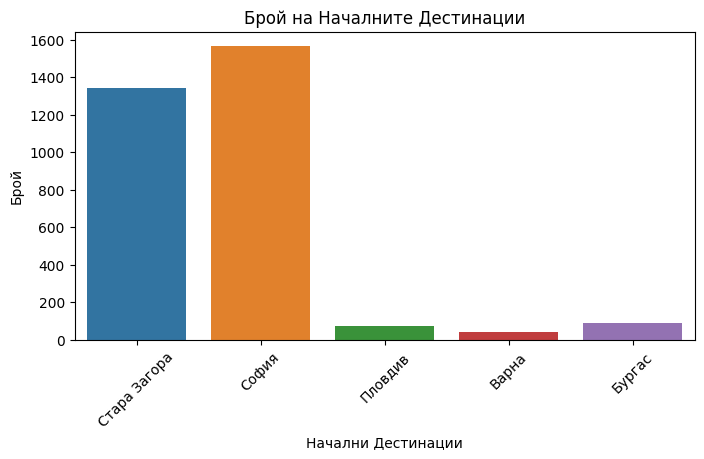

In [33]:
top_5_categories = merged_df.FromDestination.value_counts().nlargest(5).sort_index(ascending = False).index

plt.figure(figsize = (8, 4))
sns.countplot(data = merged_df[merged_df.FromDestination.isin(top_5_categories)], x = 'FromDestination', order = top_5_categories)

plt.xticks(rotation = 45)
plt.title('Брой на Началните Дестинации')
plt.xlabel('Начални Дестинации')
plt.ylabel('Брой')

plt.show()

#### Открития и препоръки:

1. Въз основа на тази информация бих препоръчал да се съсредоточим върху по-нататъшното разширяване на потребителската база извън този конкретен регион. 

2. Може да се обмисли прилагането на целеви маркетингови кампании и промоционални дейности, с цел привличането на потребители от други градове и региони. Като разнообразим потребителската база географски, можем да увеличите общия обхват и потенциалното въздействие на приложението.

<br>

### 2. Модели Автомобили

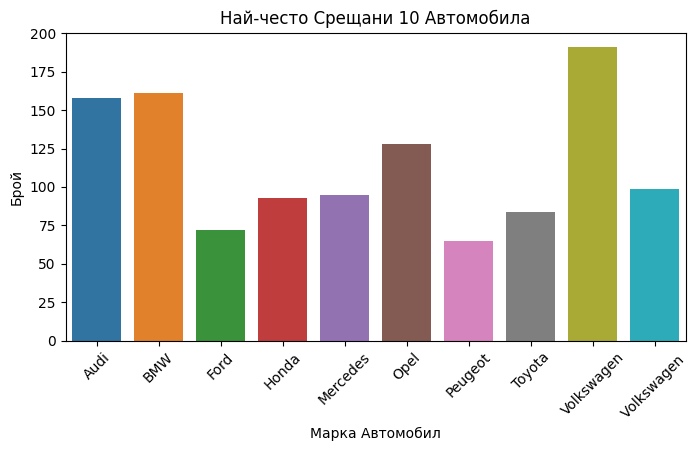

In [34]:
top_10_cars = merged_df.Brand.value_counts().nlargest(10).sort_index().index

plt.figure(figsize = (8, 4))
sns.countplot(data = merged_df[merged_df.Brand.isin(top_10_cars)], x = 'Brand', order = top_10_cars)

plt.xticks(rotation = 45)
plt.title('Най-често Срещани 10 Автомобила')
plt.xlabel('Марка Автомобил')
plt.ylabel('Брой')

plt.show()

#### Открития и препоръки:

Фактът, че най-често караните автомобили от нашите клиенти са предимно от марки като Audi, BMW, Ford, Honda, Mercedes, Opel, Peugeot, Toyota и Volkswagen, предоставя ценна информация от маркетингова гледна точка. Ето някои съображения и препоръки въз основа на тази информация:

- Целенасочена реклама: Фокусиране на рекламните усилия върху платформи и канали, които са популярни сред собствениците на тези марки автомобили. Това може да включва насочени онлайн реклами, партньорства с уебсайтове или списания, свързани с автомобилите, и сътрудничество с автокъщи.

- Партньорства с марки: Разглеждане на потенциални сътрудничества или партньорства с марките автомобили, които са популярни сред нашите клиенти. Това може да включва съвместни маркетингови кампании, специални оферти или отстъпки за техните клиенти или инициативи за кръстосано популяризиране, за да се използва съществуващата клиентска база на тези марки.

 - Персонализирано съдържание: Разработка на съдържание, което резонира с предпочитанията и интересите на собствениците на тези марки автомобили. Това може да включва публикации в блогове, съдържание в социалните медии или бюлетини, които обхващат теми като съвети за поддръжка на автомобили, препоръки за пътуване или най-новите постижения в автомобилната технология.

- Персонализирани оферти: Да помислим за персонализиране на нашите предложения или промоции специално за собствениците на тези марки автомобили. Това може да включва изключителни отстъпки, програми за лоялност или награди, които отговарят на техните предпочитания и създават усещане за афинитет и изключителност.

- Сътрудничество с общности на автомобилни ентусиасти: Ангажиране с онлайн общности, форуми или групи в социалните медии, посветени на автомобилни ентусиасти. Участвайне в дискусии, предлагане на ценна информация и демонстрация на това как нашето приложение се съгласува с интересите и нуждите на тези общности.

<br>

### 3. Година на Производство на Автомобила

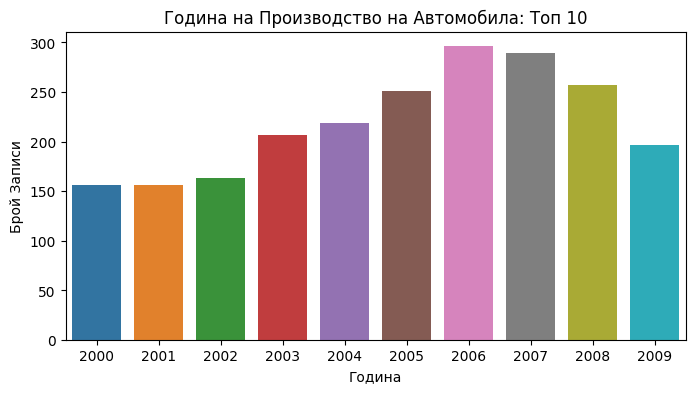

In [35]:
top_10_years = merged_df.Year.value_counts().nlargest(10).sort_index().index

plt.figure(figsize = (8, 4))
sns.countplot(data = merged_df[merged_df.Year.isin(top_10_years)], x = 'Year', order = top_10_years)

plt.title('Година на Производство на Автомобила: Топ 10')
plt.xlabel('Година')
plt.ylabel('Брой Записи')

plt.show()

#### Открития и препоръки:

Констатацията, че най-добрите 10 години, когато автомобилите на потребителите са произведени, попадат в диапазона от 2000 до 2009 г., предоставя ценна информация и отваря възможности за целенасочен маркетинг и бизнес решения. Ето някои съображения и препоръки въз основа на тази информация:

 - Целеви маркетинг: Приспособете маркетинговите си усилия, за да се погрижите за предпочитанията и нуждите на потребителите с автомобили, произведени между 2000 и 2009 г. Това може да включва създаване на конкретни маркетингови кампании, промоции или съдържание, което подчертава функции, услуги или предимства, които съответстват на характеристиките на автомобили от онази епоха.

- Партньорство с автокъщи: Сътрудничество с автокъщи, специализирани в употребявани автомобили от периода 2000-2009 г. Създаване на партньорства, които да позволяват да популяризираме приложението пред техните клиенти, или проучете възможностите за кръстосано популяризиране, които са от полза и за двете страни.

 - Услуги за поддръжка и ремонт: Разпознаване потенциалното търсене на услуги за поддръжка и ремонт сред потребителите с автомобили от този конкретен период от време. Може да помислим дали да не предложим партньорство с автосервизи или да предоставим ресурси и информация, свързани с поддръжка, части и ремонт на автомобили.

- Като се възползваме от прозрението, че значителна част от потребителската ни база притежава автомобили, произведени между 2000 и 2009 г., можем да настроим фино маркетинговите си стратегии, да създадем подходящи партньорства и да подобрим функциите на приложението, за да обслужваме по-добре тази конкретна група потребители.

<br>

### 4. Коментари

В тази секция ще обърнем внимание на най-често срещаните коментари и ще отделим Топ 10 негативни отзиви, които имат нужда от скорошно внимание.

In [36]:
stop_words = [
    'и', 'в', 'във', 'на', 'от', 'с', 'се', 'за', 'до', 'което',
    'които', 'който', 'при', 'та', 'този', 'тоз', 'тази', 'таз',
    'то', 'те', 'тя', 'той', 'него', 'нее', 'негов', 'негова', 'негово',
    'това', 'тоя', 'она', 'тях', 'аз', 'ти', 'ми', 'ви', 'го', 'го',
    'му', 'ме', 'му', 'ни', 'ну', 'нас', 'вас', 'ги', 'го', 'той',
    'не', 'ще', 'да', 'съм', 'си', 'сме', 'сте', 'са', 'беше', 'бил',
    'била', 'било', 'били', 'бях', 'беше', 'бяха', 'щеше', 'ще', 'щях',
    'щяха', 'не', 'да', 'няма', 'има', 'бил', 'била', 'било', 'били',
    'много', 'малко', 'друг', 'друга', 'други', 'един', 'една', 'едно',
    'едни', 'никои', 'никой', 'нито', 'някой', 'няма', 'няколко', 'сам',
    'сама', 'само', 'самите', 'самият', 'самата', 'самото', 'също', 'същият',
    'същата', 'същото', 'същите', 'той', 'тя', 'то', 'тези', 'този', 'тази',
    'това', 'тяхни', 'тяхната', 'тяхно', 'ваш', 'вашата', 'вашето', 'вашите',
    'тяхните', 'си', 'ни', 'ми', 'ви', 'че', 'заради', 'поради', 'затова',
    'понеже', 'без', 'срещу', 'от', 'до', 'при', 'против', 'над', 'под',
    'докато', 'дори', 'въпреки', 'всеки', 'всекиго', 'всекяка', 'всекакви',
    'когато', 'каквото', 'каквито', 'какъв', 'каква', 'какво', 'какви',
    'докато', 'преди', 'след', 'колко', 'доста', 'едва', 'едва ли', 'единствено',
    'освен', 'или', 'ли', 'не', 'дали', 'да', 'ли', 'защото', 'ако', 'понеже',
    'въпреки че', 'благодарение на', 'за да', 'тъй като', 'дори ако', 'както',
    'като че ли', 'за да не', 'и', 'дали', 'ли', 'откакто', 'по време',
    'по време на', 'докато', 'след като', 'като', 'по време', 'по време на',
    'от', 'до', 'от', 'до', 'във', 'в', 'на', 'с', 'се', 'по', 'сред',
    'преди', 'след', 'около', 'из', 'от', 'под', 'над', 'при', 'против',
    'например', 'нали', 'в', 'във', 'на', 'върху', 'всеки', 'всекиго', 'всекяка',
    'всекакви', 'каквото', 'каквито', 'какъв', 'каква', 'какво', 'какви',
    'което', 'които', 'който', 'чиято', 'чието', 'чийто', 'каква да', 'какво да',
    'какви да', 'от', 'до', 'без', 'с', 'по', 'при', 'за', 'до',
    'или', 'освен', 'близо', 'напротив', 'за сметка на', 'срещу', 'заради',
    'въпреки', 'противно на', 'вместо', 'без', 'само', 'единствено', 'било',
    'дали', 'дали не', 'дали да', 'ли', 'пак', 'отново', 'засега', 'вече',
    'отделно', 'къде', 'как', 'кога', 'колко', 'кои', 'кои да е', 'оттам',
    'там', 'тогава', 'някак', 'няколко', 'някой', 'някъде', 'няма', 'нямам',
    'няма значение', 'никак', 'никой', 'никъде', 'никога', 'да', 'не', 'не',
    'бих', 'нямам', 'не', 'нищо', 'нито', 'никой', 'дори', 'ако', 'да',
    'случайно', 'докато', 'през', 'за', 'за да', 'като', 'че', 'щото',
    'поради', 'понеже', 'тъй като', 'защото', 'това', 'така', 'така че',
    'затова', 'оттогава', 'само', 'единствено', 'освен', 'въпреки', 'вместо', 'вместо',
    'заради', 'вследствие на', 'поради', 'за', 'въпреки', 'противно на', 'например',
    'нали', 'в', 'във', 'на', 'върху', 'с', 'през', 'по', 'около',
    'върху', 'с', 'пред', 'заради', 'от', 'в', 'във', 'на', 'от', 'върху',
    'при', 'през', 'сред', 'с', 'както', 'като', 'колкото', 'например', 'то',
    'да', 'например', 'напр.', 'пр.', 'като', 'колкото', 'за', 'за да',
    'заради', 'заради това', 'поради', 'понеже', 'от', 'до', 'само', 'единствено',
    'освен', 'въпреки', 'вместо', 'без', 'близо до', 'пред', 'върху', 'над',
    'под', 'из', 'от', 'за', 'против', 'срещу', 'заради', 'поради', 'в',
    'за', 'на', 'във', 'при', 'пред', 'през', 'под', 'над', 'например',
    'като', 'за', 'от', 'до', 'преди', 'след', 'за', 'при', 'заради',
    'заради това', 'понеже', 'докато', 'ако', 'да', 'за да', 'тъй като', 'както',
    'по-късно', 'преди', 'е'
]

In [37]:
feedback = pd.read_csv("data/feedback.csv")

In [38]:
feedback.Feedback = feedback.Feedback.replace("/", ",")
feedback.Feedback = feedback.Feedback.astype(str)

In [39]:
feedback_text = ' '.join(feedback['Feedback']).replace("/", "")

words = word_tokenize(feedback_text)
filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
word_counts = Counter(filtered_words)

most_common_words = dict(word_counts.items())

In [40]:
sorted_dict = dict(sorted(most_common_words.items(), key=lambda item: item[1], reverse=True))

In [41]:
# preprocessed_sentences = [' '.join([word for word in sentence.lower().split() if word not in stop_words]) for sentence in feedback['Feedback']]

# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)

# cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# threshold = 0.3

# similar_sentences = {}
# for i, sentence in enumerate(feedback['Feedback']):
#     similar = [feedback['Feedback'][j] for j, similarity in enumerate(cosine_similarities[i]) if similarity > threshold and i != j]
#     if similar:
#         similar_sentences[sentence] = similar

# for sentence, similar in similar_sentences.items():
#     print(f"Sentence: {sentence}\n")
#     print("-------------------------------------------------------------------------------------------------------")
#     print(f"Similar sentences: {similar}\n")

### Открития:
#### Топ Негативни отзиви:

1. Когато е минал часът за тръгване пътуването изчезва от приложението. Шофьорът (или пътникът) може да има нужда да пише в чата че закъснява, но не може да му се отговори по никакъв начин.

2. След одобрение по кандидатствана обява, телефонния номер на шофьора спира да бъде видим. Има възможност за изпращане на съобщение в чата, но потренителите биха предпочели и двете страни да имат възможност за телефонна връзка.

3. Масови оплаквания от проблеми с получаването на кода за активация и имейл за потвърждение.

4. Масови оплаквания за невъзможността да се изтрие напълно акаунтът на потребителя.

5. Потребителите биха желали да могат да видят дали някой иска да пътува без да са пуснали обява.

6. Оплаквания от скоростта на приложението.

7. Ще е добре ако не се показват обявите които са без свободни места.

8. Не се получават „известия“ извън самото приложение. С други думи, потребителите биха очаквали да получават известия в статус бар-а на телефона, където се появяват всички известия от различни приложения. Доста е неудобно периодично да трябва да се влиза в апп-а, за да се проверява за такива.

9. Потребителите очакват да могат да видя дали някой иска да пътува без да са пуснали обява.

10. При забравяне на паролата не може да се промени, понеже в полето за промяна се изисква старата парола и не става през имейл. При забравяне на потребителското име след избиране на опцията забравена парола, само паролата се изпраща на пощата, а потребителите биха желали да могат да възстановят и потребителското си име.


#### Препоръки:

Повечето хора, които изпращат отзиви изглеждат объркани и не разбират как работи приложението. Имайки предвид това, силно се препоръчва улесняване на функционалностите и създаването на някакъв вид въведение за новите потребители.

Видимо липсват често срещани позитивни коментари. При това положение би било добре потребителите да бъдат насърчени да оставят повече положителни отзиви, които да повлияят на рейтинга на приложението позитивно (следват някои идеи):

- Подкани в приложението: Внедряване на подкани или изскачащи прозорци в приложението, които любезно молят потребителите да оценят и прегледат приложението ви. Можем да определим времето на тези подкани стратегически, като например след успешно изпълнение на задача или когато потребителите са били активно ангажирани с вашето приложение за определен период от време.

- Стимули или награди: Предлагане на малки стимули или награди на потребители, които оставят положителни коментари или отзиви. Това може да включва изключителни функции на приложението, отстъпки или виртуална валута в приложението. Важно е да се уверим, че сме съобщили ясно тези награди и как потребителите могат да ги поискат.

- Персонализирани заявки: Изпращайне на персонализирани съобщения или известия до активни и лоялни потребители, изразяващи признателност за тяхната подкрепа и любезно приканване да споделят своите положителни преживявания, като оставят отзив или коментар. Персонализираните заявки могат да накарат потребителите да се чувстват ценени и по-склонни да дадат своя принос.

- Ангажираност в социалните медии: Популяризиране на препоръките на потребителите и положителните коментари във вашите канали в социалните медии. Маркиране и споделяне на положителни отзиви от потребителите, създавайки усещане за общност и насърчавайки другите също да споделят своя опит.

- Опростяване на процеса на обратна връзка: Улесняване на потребителите да предоставят обратна връзка в рамките на приложението, като включим забележим и удобен за потребителя формуляр за обратна връзка. Опростяване на процеса, като се задават конкретни въпроси или предоставяме предварително дефинирани опции, гарантирайки, че потребителите могат бързо и без усилие да оставят своите коментари.

- Отговаряне и ангажиране: Активно ангажиране с потребители, които оставят положителни коментари или отзиви, като се отговаря на техните отзиви. Благодарност за тяхната подкрепа, отговори на всичките им въпроси или притеснения и посочване, че техните мнения имат значение. Това ниво на ангажираност може да насърчи положителна връзка и да насърчи повече потребители да споделят своя опит.

<br>

## Анализ на Финансови Данни

В следващата секция реално няма да анализираме финансовите данни. Поради огромният брой различни наблюдения и сравнително ниският брой записи (приблизително само 5 месеца) този анализ ще бъде старателно прегледан в бъдещето, след като потребителската база е разширена. Тогава ще се изберат необходимите фактори, които искаме да проучим с цел по-добро опознаване на потребителската база.

- Това, което ще направим сега, е едно предвиждане с помощта на Линейна Регресия, което има за цел да покаже какъв би бил дневният приход при положение, че нищо не се промени в приложението.

In [42]:
data = pd.read_csv("data/new_and_renewal_revenue.csv")

In [43]:
data.tail()

,Report Date,New Revenue,Renewal Revenue,Total Revenue,Store Commission / Fee,Estimated Taxes,Proceeds
125,2023-06-05,13.69,10.39,24.08,3.60,3.36,17.07
126,2023-06-06,3.28,27.98,31.26,4.49,4.62,22.11
127,2023-06-07,15.85,32.78,48.63,7.06,7.11,34.43
128,2023-06-08,3.28,10.39,13.67,1.97,2.00,9.67
129,2023-06-09,3.85,29.15,33.00,4.59,5.03,23.40


In [44]:
# Convert 'Report Date' column to datetime type
data['Report Date'] = pd.to_datetime(data['Report Date'])

# Date-based features
data['DayOfWeek'] = data['Report Date'].dt.dayofweek
data['Month'] = data['Report Date'].dt.month
data['Quarter'] = data['Report Date'].dt.quarter
data['Year'] = data['Report Date'].dt.year

In [45]:
# Rolling statistics
data['New Revenue Rolling Mean'] = data['New Revenue'].rolling(window=3, min_periods=1).mean()
data['New Revenue Rolling Sum'] = data['New Revenue'].rolling(window=7, min_periods=1).sum()

In [46]:
# Ratios or percentages
data['Renewal Revenue Ratio'] = data['Renewal Revenue'] / data['Total Revenue']

In [47]:
# Difference or change features
data['New Revenue Diff'] = data['New Revenue'].diff()
data['New Revenue Percent Change'] = data['New Revenue'].pct_change()

In [48]:
# Lagged features
data['Lagged New Revenue'] = data['New Revenue'].shift(1)

In [49]:
# Interaction features
data['New Revenue Commission Interaction'] = data['New Revenue'] * data['Store Commission / Fee']

# Moving averages
data['New Revenue Moving Average'] = data['New Revenue'].rolling(window = 30).mean()

In [50]:
data = data.fillna(data.mean())

In [51]:
# Replace 'inf' values with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Replace NaN values with column mean
data = data.fillna(data.mean())

In [52]:
X = data.drop(columns = ['Proceeds', 'Report Date'])
y = data['Proceeds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of the GradientBoostingRegressor
model =  LinearRegression()

# Fit the booster to the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print('R-squared Score:', r2)

Mean Squared Error: 0.0006950917602096972
R-squared Score: 0.9999922338280879


In [53]:
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Mean MSE:", positive_scores.mean())
print("Cross-Validation Standard Deviation MSE:", positive_scores.std())

Cross-Validation Mean MSE: 1.2171012431172203
Cross-Validation Standard Deviation MSE: 3.6484230318854096


In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Extract the 'Proceeds' column
proceeds = data['Proceeds']

train_data = proceeds[:-6]
test_data = proceeds[-6:]

model = SARIMAX(train_data, order = (1, 0, 1), seasonal_order = (0, 1, 1, 7), )
model_fit = model.fit()

forecast = model_fit.forecast(steps = 6)

predictions = pd.DataFrame(forecast.values)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25605D+00    |proj g|=  2.03368D-01

At iterate    5    f=  4.17249D+00    |proj g|=  1.36798D-02

At iterate   10    f=  4.13281D+00    |proj g|=  6.23518D-03

At iterate   15    f=  4.12765D+00    |proj g|=  4.45513D-03

At iterate   20    f=  4.12288D+00    |proj g|=  4.13415D-04

At iterate   25    f=  4.12207D+00    |proj g|=  5.93033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   

 This problem is unconstrained.


In [55]:
predictions

,0
0,16.140907
1,13.468723
2,14.151191
3,19.718994
4,15.963735
5,12.044829


### Открития:

- Може да видим, че дневният приход за следващите 6 месеца варира в рамките на 12-19 щатски долара. Ако пресметнем средното аритметично, очакваният приход за месец би бил около 465 щатски долара.

- Това, което е повече от ясно и се потвърждава от този модел е, че без разширяване на потребителската база, приходите най-вероятно да продължат да намаляват значително. Имайки предвид, че от Януари до сега са паднали почти двойно, тази тенденция е възможно да продължи и занапред (може би не лятото, защото хората пътуват по-често, но след летният сезон със сигурност).

#### За това финалната ми препоръка е да се вложат всички усилия и ресурси в:

- Подобряване функционалността на приложението

- Таргетирана реклама

- Сериозно засилване на присъствието ни в социалните мрежи и публичните събития, които биха били подходящи
  

#### Наблягам на спешността на тези 3 теми, без които бъдещо развитие и потенциал за финансиране биха били немислими.

<br>

<br>

Тихомир Тодоров

13 Юни 2023